In [34]:
import numpy as np
from scipy.optimize import minimize, basinhopping
import matplotlib.pyplot as plt
from dataclasses import dataclass

# Exercice

Résoudre numériquement le problème de maximisation de l'utilité.

In [13]:
@dataclass
class Utilite:
    a: float
    b: float
    d: float
    
    def __post_init__(self):
        if self.a <= 0 or self.b <= 0:
            raise ValueError("a et b sont strictements positifs!")
        if abs(self.d) >= self.b:
            raise ValueError(" |d| < b")
            
    def __call__(self, qs):
        q0, q1, q2 = qs
        return (
            self.a * (q1 + q2) + q0 
            - (self.b * (q1 ** 2 + q2 ** 2) + 2 * self.d *q1 * q2) / 2
        )
        


In [14]:
u = Utilite(a=1, b=2, d=1)

In [15]:
u

Utilite(a=1, b=2, d=1)

In [16]:
u([1, 0, 1])

1.0

In [25]:
# pour une alternative à dataclass
class Contrainte:
    def __init__(self, p1, p2, R):
        if p1 < 0 or p2 < 0 or R < 0:
            raise ValueError("Les coefficients de contraintes doivent être positifs.")
        self.p1 = p1
        self.p2 = p2
        self.R = R
        
    def __repr__(self):
        return f"Contrainte(p1={self.p1}, p2={self.p2}, R={self.R})" 
    
    def __call__(self, qs):
        q0, q1, q2 = qs
        return self.R - q0 - self.p1 * q1 - self.p2 * q2

In [26]:
c = Contrainte(1, 1, 1)

In [27]:
c

Contrainte(p1=1, p2=1, R=1)

In [28]:
c([1, 1, 1])

-2

In [32]:
def consommateur(
        utilite: Utilite, 
        contrainte: Contrainte
    )    -> tuple[float, float, float]:
    resultat = minimize(
        fun=lambda x: -utilite(x),
        x0=np.array([0, 0, 0]),
        bounds=((0, None), (0, None), (0,None)),
        constraints={"type": "ineq", "fun": contrainte},
    )
    if resultat.success:
        return resultat.x
    else: 
        raise ValueError("Impossible de déterminer le maximiseur.")
    

In [33]:
consommateur(utilite=u, contrainte=c)

array([1., 0., 0.])

# Exercice

Comment ajuster la fonction pour essayer d'avoir des maximums globaux et pas juste locaux?

1. On peut garder la même méthode mais faire varier les $x0$ puis comparer les maximiseurs obtenus.
2. On peut utiliser la fonction `basinhopping` mais il faut encoder les contraintes dans la fonction à minimiser.

# Exercice

En résolvant le problème de minimisation sous contrainte $\mathcal{P}$ on a trouvé des fonctions
$$\tilde{q_i}: (p_1, p_2) \mapsto \mathrm{argmin} \mathcal{P}.$$

Visualiser les fonctions $\tilde{q_i}$. 
Avec des heatmaps puis avec des surfaces 3d.

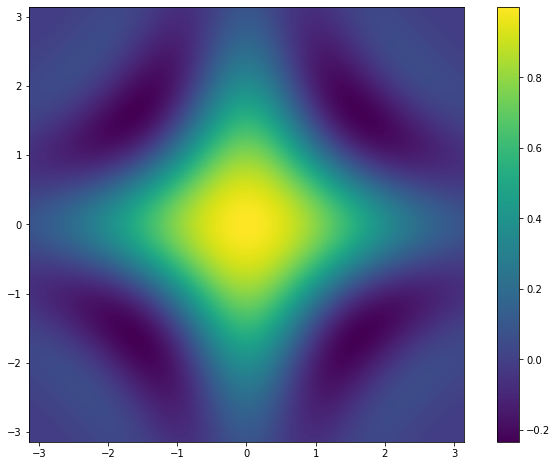

In [49]:
# exemple pour imshow
fig, rep = plt.subplots(figsize=(12, 8))
xs= np.linspace(-np.pi, np.pi, 200) 
ys = np.linspace(-np.pi, np.pi, 200)[::-1]
X, Y = np.meshgrid(xs, ys)
Z = np.exp(-(X**2 + Y**2) / 4) * np.cos(X * Y)
image = rep.imshow(Z, extent=(-np.pi, np.pi, -np.pi, np.pi))
fig.colorbar(image)

In [50]:
def calcule(p1max, p2max, nb_points=50, a=1, b=2, d=1, R=2):
    u = Utilite(a, b, d)
    c = Contrainte(0, 0, R)
    q0s = list()
    q1s = list()
    q2s = list()
    p1s = np.linspace(0, p1max, nb_points)
    p2s = np.linspace(0, p2max, nb_points)[::-1]
    for p1 in p1s:
        l0, l1, l2 = list(), list(), list()
        for p2 in p2s:
            c.p1 = p1
            c.p2 = p2
            q0, q1, q2 = consommateur(u, c)
            l0.append(q0)
            l1.append(q1)
            l2.append(q2)
        q0s.append(l0)
        q1s.append(l1)
        q2s.append(l2)
    return q0s, q1s, q2s

In [52]:
q0s, q1s, q2s = calcule(1, 1, nb_points=100)

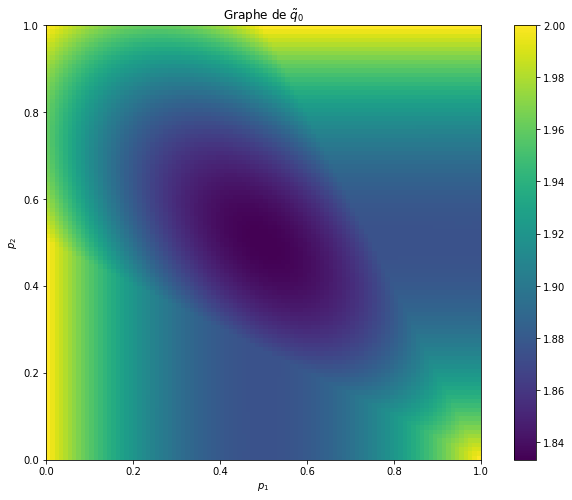

In [59]:
fig, rep = plt.subplots(figsize=(12, 8))
im = rep.imshow(q0s, extent=(0, 1, 0, 1))
rep.set_title("Graphe de $\\tilde{q}_0$")
rep.set_xlabel("$p_1$")
rep.set_ylabel("$p_2$")
fig.colorbar(im)

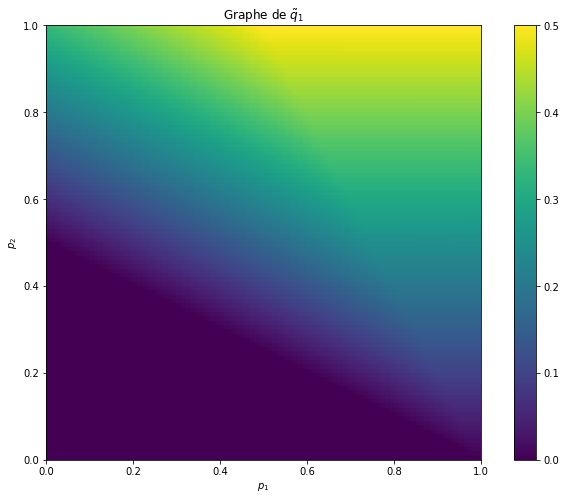

In [60]:
fig, rep = plt.subplots(figsize=(12, 8))
im = rep.imshow(q1s, extent=(0, 1, 0, 1))
rep.set_title("Graphe de $\\tilde{q}_1$")
rep.set_xlabel("$p_1$")
rep.set_ylabel("$p_2$")
fig.colorbar(im)

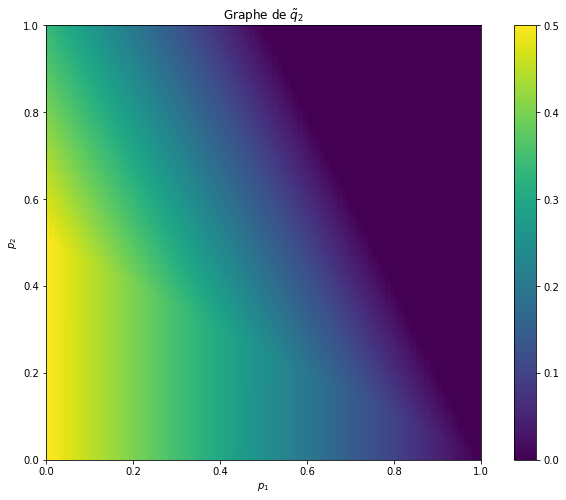

In [61]:
fig, rep = plt.subplots(figsize=(12, 8))
im = rep.imshow(q2s, extent=(0, 1, 0, 1))
rep.set_title("Graphe de $\\tilde{q}_2$")
rep.set_xlabel("$p_1$")
rep.set_ylabel("$p_2$")
fig.colorbar(im)

# Visualisation des ensembles de niveaux de la fonctions d'utilité

In [62]:
import plotly.graph_objects as go

In [63]:
u = Utilite(a=1, b=2, d=1)
c = Contrainte(p1 = 2, p2 = 1.9, R=10)

In [77]:
q0s = np.linspace(0, c.R, 30)
q1s = np.linspace(0, c.R / c.p1, 30)
q2s = np.linspace(0, c.R / c.p2, 30)
Q0, Q1, Q2 = np.meshgrid(q0s, q1s, q2s)
us = u((Q0, Q1, Q2))
fig = go.Figure(
    data=go.Isosurface(
        value=us.flatten(),
        x=Q0.flatten(),
        y=Q1.flatten(),
        z=Q2.flatten(),
        isomin=0, 
        isomax=c.R,
        surface_count=5,
        caps={"x_show": False, "y_show": False, "z_show": False}
    ),
    layout={
        "width": 800,
        "height": 600,
    }
)

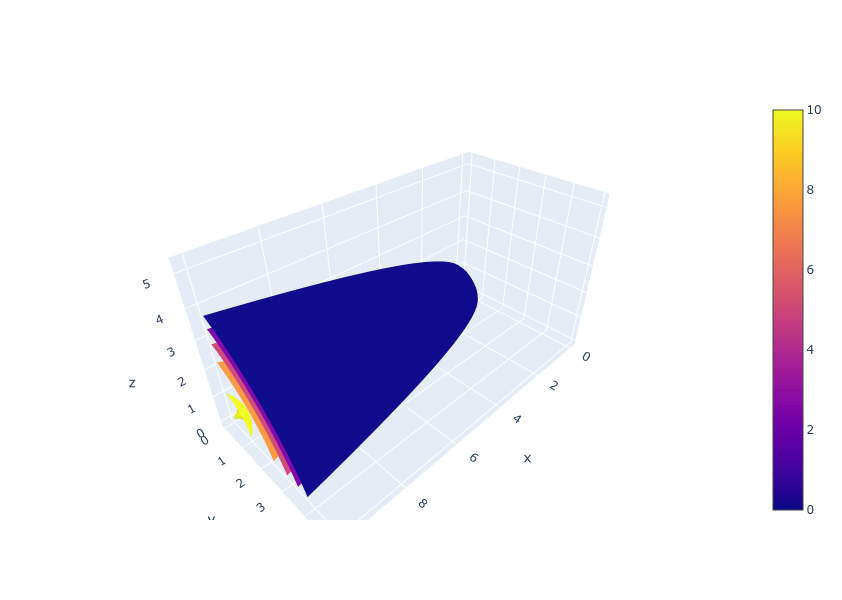

In [78]:
fig.show()

# Exercice 

1. Rajouter la contrainte dans le graphe.
2. Rajouter de l'interactivité sur les autres paramètres grâce à la bibliothèque `dash`.

In [79]:
dir(fig)

['__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_annotation_like',
 '_allow_disable_validation',
 '_animation_duration_validator',
 '_animation_easing_validator',
 '_batch_layout_edits',
 '_batch_trace_edits',
 '_bracket_re',
 '_build_dispatch_plan',
 '_build_update_params_from_batch',
 '_config',
 '_data',
 '_data_defaults',
 '_data_objs',
 '_data_validator',
 '_dispatch_layout_change_callbacks',
 '_dispatch_trace_change_callbacks',
 '_filter_by_selector',
 '_frame_objs',
 '_frames_validator',
 '_get_child_prop_defaults',
 '_get_child_props',
 '_get_subplot_coordinates',
 '_get_subplot_rows_columns',
 